<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Download data

In [3]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

# import python libraries

- numpy
- pandas
- pytorch
- scikit
- matplotlib

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from scipy.sparse import *
import sklearn.utils
import matplotlib.pyplot as plt

# Set up functions

- **shuffle** shuffles pandas dataframe
- **make_labels** takes in pandas dataframe and transforms it into tensor
- **create_dataset** takes anger and joy files, opens them into pandas dataframe and changing labels not-joy and not-anger into neutral
- **create_dataset_and_testset** takes in pandas dataframes and tranforms them into pytorch tensor
- **score** takes in model and tensors, scoring them
- **torch_shuffle** -- incomplete

In [5]:
def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [6]:
def make_labels(labels):
  y = []
  for i in labels:
    if i == 'joy':
      y.append([1,0,0])
    elif i == 'anger':
      y.append([0,1,0])
    elif i == 'neutral':
      y.append([0,0,1])
  y = torch.tensor(y).float()
  return y

In [7]:
def create_dataset(angerpath, joypath):
  anger = pd.read_csv(angerpath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
  joy= pd.read_csv(joypath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

  df = pd.concat([joy, anger])
  df['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
  df = shuffle(df)

  return df

In [8]:
def create_dataset_and_testset(pandas_dataset, vectorizer):

  feature_matrix = vectorizer.transform(pandas_dataset['text'])
  mat = feature_matrix.astype('float').toarray()
  X = torch.from_numpy(mat)
  y = make_labels(pandas_dataset['emotion'])

  return X, y

In [9]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    pred = model(dataset[i].float())
    n1 = pred.detach().cpu().numpy().argmax()
    n2 = labels[i].detach().cpu().numpy().argmax()
    if n2 == n1:
      total += 1
    
  return total/dataset_size*100

In [123]:
def torch_shuffle(df, vectorizer):
  df = shuffle(df)
  X, y = create_dataset_and_testset(df, vectorizer)
  return X, y

# Initialize data

In [11]:
dataset = create_dataset('/content/anger-train.tsv', '/content/joy-train.tsv')
vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,1))
vectorizer.fit(dataset['text'])
dataset_train, labels_train = create_dataset_and_testset(dataset, vectorizer)

In [12]:
dataframe_dev = create_dataset('/content/anger-dev.tsv', '/content/joy-dev.tsv')
dataset_dev, labels_dev = create_dataset_and_testset(dataframe_dev, vectorizer)

In [13]:
dataframe_test = create_dataset('/content/anger-test.tsv', '/content/joy-test.tsv')
dataset_test, labels_test = create_dataset_and_testset(dataframe_test, vectorizer)

# Setup pytorch device

In [186]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [187]:
dataset_train = dataset_train.to(device)
labels_train = labels_train.to(device)

dataset_dev = dataset_dev.to(device)
labels_dev = labels_dev.to(device)

dataset_test = dataset_test.to(device)
labels_test = labels_test.to(device)

# Init neural network

In [188]:
class Net(nn.Module):
  def __init__(self, size):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(size, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, X):

    out = self.fc1(X)
    out = torch.relu(out)

    out = self.fc2(out)

    return out

# Setup neural network, loss function and optimizer

In [289]:
vocab_size = dataset_train.shape[1]
model = Net(vocab_size)

loss_function = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.4)

accuracy = []
losses = []

model = model.to(device)
loss_function = loss_function.to(device)

# Train model

In [290]:
for epoch in range(50):
  print('epoch ', epoch, ' loss ', round(running_loss,3))
  running_loss = 0.0

  for i in range(2025):    
    optimizer.zero_grad()

    out = model(dataset_train[i].float())
    loss = loss_function(out, labels_train[i])
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        accuracy.append(score(model, dataset_train[:50], labels_train[:50], 50))
        losses.append(running_loss/100)
        running_loss = 0.0

epoch  0  loss  0.028
epoch  1  loss  4.772
epoch  2  loss  4.719
epoch  3  loss  4.707
epoch  4  loss  4.675
epoch  5  loss  4.64
epoch  6  loss  4.622
epoch  7  loss  4.541
epoch  8  loss  4.508
epoch  9  loss  4.338
epoch  10  loss  4.175
epoch  11  loss  4.028
epoch  12  loss  3.682
epoch  13  loss  3.588
epoch  14  loss  3.11
epoch  15  loss  2.735
epoch  16  loss  2.734
epoch  17  loss  2.281
epoch  18  loss  2.219
epoch  19  loss  2.036
epoch  20  loss  2.01
epoch  21  loss  1.937
epoch  22  loss  2.019
epoch  23  loss  1.828
epoch  24  loss  1.799
epoch  25  loss  1.884
epoch  26  loss  1.774
epoch  27  loss  1.71
epoch  28  loss  1.722
epoch  29  loss  1.71
epoch  30  loss  1.502
epoch  31  loss  1.731
epoch  32  loss  1.391
epoch  33  loss  1.565
epoch  34  loss  1.359
epoch  35  loss  1.345
epoch  36  loss  1.527
epoch  37  loss  1.131
epoch  38  loss  1.346
epoch  39  loss  1.344
epoch  40  loss  1.234
epoch  41  loss  1.109
epoch  42  loss  1.243
epoch  43  loss  1.109
epo

# SCORES

In [291]:
print('Train ', round(score(model, dataset_train, labels_train, dataset_size=2025), 3))
print('Devel ', round(score(model, dataset_dev, labels_dev, dataframe_dev.shape[0]), 3))
print('Test ', round(score(model, dataset_test, labels_test, dataframe_test.shape[0]), 3))

Train  99.309
Devel  80.667
Test  79.223


# Statistics

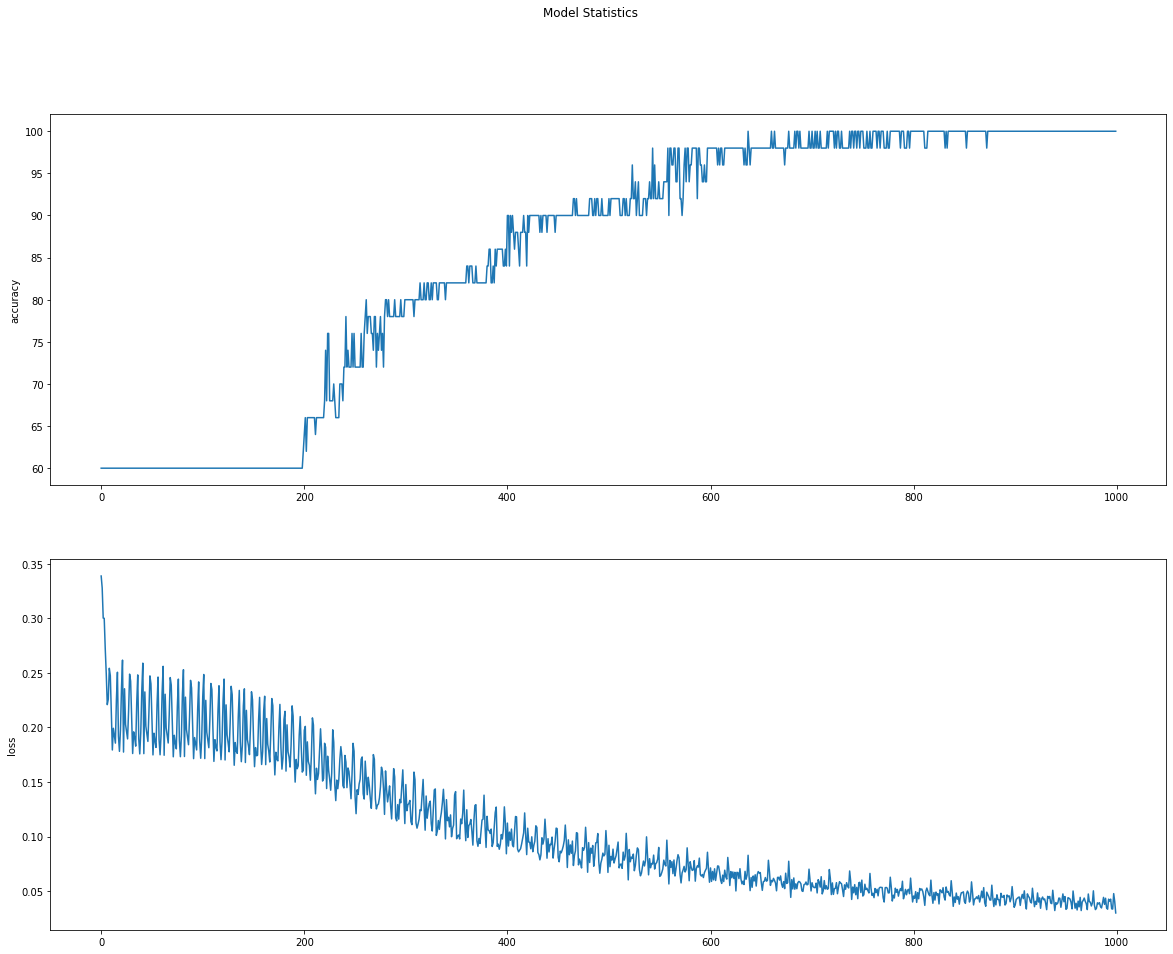

In [292]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()